## Runnning with gammapy-dev/IRF_model

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

In [2]:
from matplotlib import rc

rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [3]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [4]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(sys)

Eff_area_1TeV_10per


In [5]:
parameter_names_1  = set(list(np.array(parameter_names).ravel()))
for p in parameter_names_1:
    print(p)

lambda_
index
amplitude


## Datasets

In [6]:
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None) 
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
dataset_asimov, dataset_asimov_N = setup.apply_config_settings(dataset_asimov, dataset_asimov_N, c)



loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/Dataset/datasets/dataset-simulated-2.154434690031884-hr.fits.gz
reference 1.0
IRFModels

  Name                      : dataset_N-irf
  Datasets names            : dataset_N
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffAreaIRFModel
  PSF model type            : 
  Parameters:
    bias       (frozen)        :      0.000                  
    resolution (frozen)        :      0.000                  
    norm               [prior] :      0.000  +/-    0.00             
    tilt               [prior] :      0.000  +/-    0.00             
    reference  (frozen)        :      1.000      TeV         




## Scan

In [7]:
parameter_names_1

{'amplitude', 'index', 'lambda_'}

In [8]:
def computing_scan(dataset, note):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models)
    
    results = []
    for parname1 in parameter_names_1 :
        if parname1 == 'lambda_':
            print("scanning",  parname1)
            dataset.models.parameters[parname1].scan_n_values=numpoints
            result = fit_cor.stat_profile(dataset,
                                 dataset.models.parameters[parname1],
                                reoptimize = True
                                )

            contour_write = dict()
            for k in result.keys():
                print(k)
                if k != "fit_results":
                    contour_write[k] = [float(_) for _ in result[k]]#.tolist()
            print(contour_write)
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "w") as outfile:
                yaml.dump(contour_write, outfile, default_flow_style=False)

            results.append(result)
    return results
        
def read_in_scan(note):
    results = []
    for parname1 in parameter_names_1 :
        try:
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
        except:
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
        results.append(contour)
    return results


In [9]:
%%time
numpoints = 20
computing = 0
if computing:
    results = computing_scan(dataset_asimov, "2.15h")
else:
    results = read_in_scan("2.15h")
    path = f'../{folder}/data/0_model.yml'
    dataset_asimov.models = Models.read(path)
    


CPU times: user 26.7 ms, sys: 0 ns, total: 26.7 ms
Wall time: 85.7 ms


In [10]:
%%time
computing = 0
numpoints = 20

if computing:
    dataset_asimov_N.models.parameters['lon_0'].frozen = True
    dataset_asimov_N.models.parameters['lat_0'].frozen = True
    
    results_N = computing_scan(dataset_asimov_N, "N_2.15h")
else:
    results_N = read_in_scan("N_2.15h")
    try:
        path = f'../{folder}/data/0_model_nui.yml'
        dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    except:
        path = f'../{folder}/data/0_model_nui_1000.yml'
        dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
        
print(results_N)

[{'Crablog.spectral.lambda__scan': [0.02381642054800938, 0.03183544251189816, 0.039854464475786944, 0.047873486439675726, 0.05589250840356451, 0.06391153036745328, 0.07193055233134207, 0.07994957429523086, 0.08796859625911964, 0.09598761822300843, 0.1040066401868972, 0.11202566215078598, 0.12004468411467477, 0.12806370607856354, 0.13608272804245233, 0.14410175000634112, 0.15212077197022988, 0.1601397939341187, 0.16815881589800746, 0.17617783786189622], 'stat_scan': [89289.45501028483, 89288.1621315595, 89287.11264101967, 89286.26696422668, 89285.59492280171, 89285.07294085388, 89284.68220730146, 89284.40742306843, 89284.23593274776, 89284.15711134323, 89284.1619227778, 89284.24259602732, 89284.39238179928, 89284.60536970824, 89284.87634482118, 89285.20067607304, 89285.5742274287, 89285.99328633882, 89286.4545054284, 89286.95485452816]}, {'Crablog.spectral.index_scan': [2.119712952863358, 2.138748603448013, 2.157784254032668, 2.1768199046173233, 2.1958555552019785, 2.2148912057866337, 2

In [11]:
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : Z6XI4n1U
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.302  +/-    0.09             
    amplitude                  :   3.85e-11  +/- 4.7e-12 1 / (cm2 s TeV)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.100  +/-    0.04 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0                      :    329.680  +/-    0.00 deg         
    lat_0                      :    -30.222  +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-fit-bkg
  Datasets names            : ['dataset-fit']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                       :      1.000  +/-    0.01     

In [12]:
import colors as s
s.blue

[0.12156862745098039, 0.47058823529411764, 0.7058823529411765]

<Figure size 640x480 with 0 Axes>

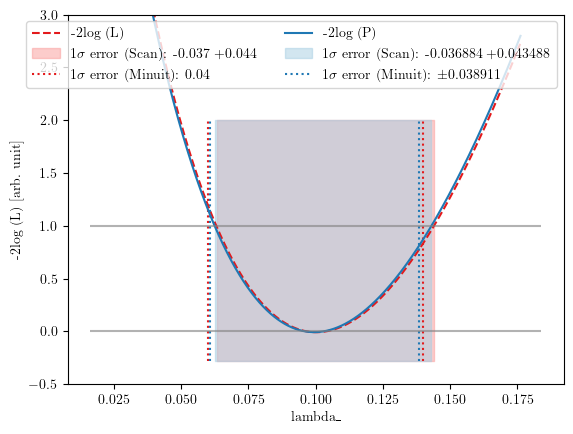

<Figure size 640x480 with 0 Axes>

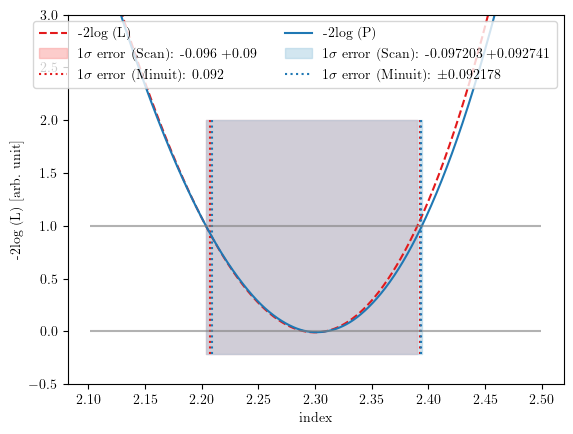

<Figure size 640x480 with 0 Axes>

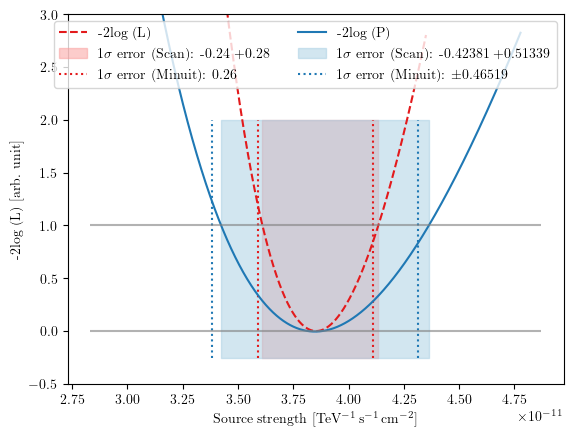

In [13]:
import upper_limit_18_02

colors_ = [s.blue, s.orange,
          s.lblue, s.lorange]

colors_ = [awo[0] , aw[0],
           awo[1] , aw[1]]

for i, p in enumerate(parameter_names_1):
    #if p == 'index':
    if True:
        stat_profile_N = results_N[i]
        stat_profile = results[i]

        stat_profile_N['stat_scan'] -= np.min(stat_profile_N['stat_scan'])
        stat_profile['stat_scan'] -= np.min(stat_profile['stat_scan'])

        fig = plt.figure()
        ll_N_a = stat_profile_N.copy()
        case = 'spectral'
        if p == 'sigma':
            case = 'spatial'
            
        amplitude_err = dataset_asimov.models[0].parameters[p].error
        amplitude = dataset_asimov.models[0].parameters[p].value
        amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
        amplitude_N = dataset_asimov_N.models[0].parameters[p].value

        fig, ax = plt.subplots(1,1)
            
        ### LIKELIHOOD
        # scan
        ll_a = stat_profile.copy()
        ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_a, x_a = ul_a.interpolate()
        plt.plot(x_a, L_a(x_a),label = "-2log (L)", linestyle = 'dashed', color = colors_[0])
    
        ylim= ax.get_ylim()
        ymax = 2#ylim[1]
        min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov.models.parameters[p].error_n = er_neg
        dataset_asimov.models.parameters[p].error_p = er_pos
        
        factor = 1
        if p == 'amplitude':
            factor = 1e11

        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ymax, alpha = 0.5, color=colors_[2],
                        label = f'1$\sigma$ error (Scan): -{er_neg*factor:.2} +{er_pos*factor:.2} ')
     
        
        ax.vlines(amplitude-amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted')
        ax.vlines(amplitude+amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted',
                 label =  f'1$\sigma$ error (Minuit): {amplitude_err*factor:.2}')

           
        ### POSTERIOR
        # scan
        ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                               name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_N_a, x_N_a = ul_N_a.interpolate()
        plt.plot(x_N_a, L_N_a(x_N_a),label = "-2log (P)", color = colors_[1])
        
        
        min_N, er_negN, er_posN = ul_N_a.likelihood_error_asymmetric()
        min_N = min_N[0]; er_negN = er_negN[0]; er_posN = er_posN[0]; 
        dataset_asimov_N.models.parameters[p].error_n = er_negN
        dataset_asimov_N.models.parameters[p].error_p = er_posN


        ax.fill_between(  [min_N-er_negN, min_N+ er_posN], ylim[0], ymax, alpha = 0.5, color = colors_[3],
                        label = f'1$\sigma$ error (Scan): -{er_negN*factor:.5} +{er_posN*factor:.5} ')
        ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ymax,color = colors_[1] ,
                  linestyles='dotted'
                 )
        ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ymax,color = colors_[1],
                  linestyles='dotted',
                    label = f'1$\sigma$ error (Minuit): $\pm${amplitude_err_N*factor:.5}')
                 
        nn = 2
        #ax.set_xlim(amplitude_N-amplitude_err_N*nn, 
        #           amplitude_N+amplitude_err_N*nn)
        ax.set_ylim(np.min(stat_profile['stat_scan'])-0.5,
                    np.min(stat_profile['stat_scan'])+ 3)

        
        
       
    
    
        xx = ax.get_xlim()
        alpha = 0.6
        ax.hlines(0, xx[0], xx[1], color = 'grey', alpha = alpha)
        ax.hlines(1, xx[0], xx[1], color = 'grey', alpha = alpha)
        if p == 'amplitude':
            str_= "[$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]"
            plt.xlabel(f"Source strength " + str_) 
        else:
            plt.xlabel(p)
        plt.ylabel("-2log (L) [arb. unit]")
        plt.legend(ncol = 2)

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}.pdf")
    
    

In [14]:
path = f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml'
dataset_asimov_N.models.write(path, overwrite = 1)

path = f'../{folder}/data/0_model_livetime_{livetime}_np.yml'
dataset_asimov.models.write(path, overwrite = 1)

In [15]:
print(dataset_asimov_N.models.parameters['index'].error)
print(dataset_asimov_N.models.parameters['index'].error_n)
print(dataset_asimov_N.models.parameters['index'].error_p)
print(dataset_asimov_N.models.parameters['index'].value)


0.09217801561099592
0.09720305203514856
0.09274087718986257
2.3017402437850563


In [16]:
print(dataset_asimov.models.parameters['index'].error)
print(dataset_asimov.models.parameters['index'].error_n)
print(dataset_asimov.models.parameters['index'].error_p)
print(dataset_asimov.models.parameters['index'].value)

0.09232004913014927
0.09583988422704826
0.09019532662839991
2.3


## Minos

In [17]:
lt = c['livetime']

In [18]:
%%time
compute_minos = 0
if compute_minos :
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset_asimov)
    result_cor.minuit.minos()
   

    minos_model = Models(dataset_asimov.models.copy() )
    for p in result_cor.minuit.parameters:
        p_ = p[8:]
        factor = 1 
        if p_ == "amplitude":
            factor = dataset_asimov.models.parameters['amplitude'].scale
        
        minos_model.parameters[p_].error_n = fit_cor.minuit.merrors[p].lower* factor
        minos_model.parameters[p_].error_p = fit_cor.minuit.merrors[p].upper* factor
    minos_model.write(f'../{folder}/data/4_minos_error_{lt}.yaml', overwrite = True)


    fit_cor_N = Fit(store_trace=False)
    result_cor_N = fit_cor_N.run(dataset_asimov_N)
    result_cor_N.minuit.minos()

    minos_model_N = Models(dataset_asimov_N.models.copy() )
    for p in result_cor_N.minuit.parameters:
        p_ = p[8:]
        print(p_)
        factor = 1 
        if p_ == "amplitude":
            factor = dataset_asimov.models.parameters['amplitude'].scale
        minos_model_N.parameters[p_].error_n = fit_cor_N.minuit.merrors[p].lower* factor
        minos_model_N.parameters[p_].error_p = fit_cor_N.minuit.merrors[p].upper* factor
        print(fit_cor_N.minuit.merrors[p].lower* factor)
    minos_model_N.write(f'../{folder}/data/4_minos_error_{lt}_nui.yaml', overwrite = True)
    

    
    
else:
    minos_model_N = Models.read(f'../{folder}/data/4_minos_error_{lt}_nui.yaml')    
    minos_model = Models.read(f'../{folder}/data/4_minos_error_{lt}.yaml')
    
minos_model_N.parameters['lambda_'].error_n *= 0.01
minos_model_N.parameters['lambda_'].error_p *= 0.01

minos_model.parameters['lambda_'].error_n *= 0.1
minos_model.parameters['lambda_'].error_p *= 0.1

minos_model_N.parameters['index'].value = dataset_asimov_N.models.parameters['index'].value
minos_model_N.parameters['lambda_'].value = dataset_asimov_N.models.parameters['lambda_'].value
minos_model_N.parameters['amplitude'].value = dataset_asimov_N.models.parameters['amplitude'].value





<timed exec>:15: GammapyDeprecationWarning: The IMinuit object is attached to the OptimizeResult object instead.
<timed exec>:16: GammapyDeprecationWarning: The IMinuit object is attached to the OptimizeResult object instead.


KeyboardInterrupt: 

In [19]:
print(minos_model.parameters['index'].error)
print(minos_model.parameters['index'].error_n)
print(minos_model.parameters['index'].error_p)
print(minos_model.parameters['index'].value)


0.0881902135063954
-0.09571183332800573
0.09000986743820563
2.3026114784838456


In [20]:
print(dataset_asimov.models.parameters['index'].error)
print(dataset_asimov.models.parameters['index'].error_n)
print(dataset_asimov.models.parameters['index'].error_p)
print(dataset_asimov.models.parameters['index'].value)


0.0881902135063954
0.09583988422704826
0.09019532662839991
2.3026114784838456


In [21]:
dataset_asimov_N.models.parameters['index'].error_n

0.09720305203514856

lambda_
0.10003403025494313


NameError: name 'minos_model_N' is not defined

<Figure size 640x480 with 0 Axes>

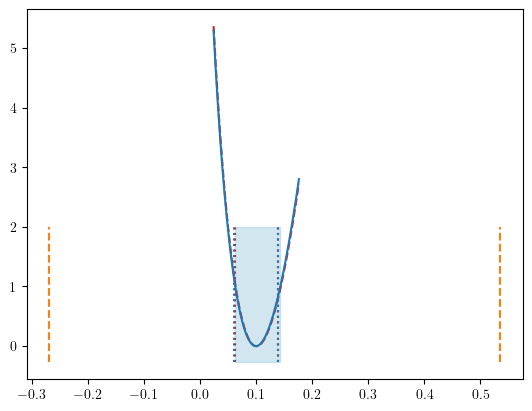

In [22]:
import upper_limit_18_02

colors_ = [s.blue, s.orange,
          s.lblue, s.lorange]

colors_ = [awo[0] , aw[0],
           awo[1] , aw[1]]

for i, p in enumerate(parameter_names_1):
    #if p == 'index':
    if True:
        print(p)
        stat_profile_N = results_N[i]
        stat_profile = results[i]

        stat_profile_N['stat_scan'] -= np.min(stat_profile_N['stat_scan'])
        stat_profile['stat_scan'] -= np.min(stat_profile['stat_scan'])

        fig = plt.figure()
        ll_N_a = stat_profile_N.copy()
        case = 'spectral'
        if p == 'sigma':
            case = 'spatial'
            
        amplitude_err = dataset_asimov.models[0].parameters[p].error
        amplitude = dataset_asimov.models[0].parameters[p].value
        amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
        amplitude_N = dataset_asimov_N.models[0].parameters[p].value

        fig, ax = plt.subplots(1,1)
            
        ### LIKELIHOOD
        # scan
        ll_a = stat_profile.copy()
        ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_a, x_a = ul_a.interpolate()
        plt.plot(x_a, L_a(x_a),label = "-2log (L)", linestyle = 'dashed', color = colors_[0])
    
        ylim= ax.get_ylim()
        ymax = 2#ylim[1]
        min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov.models.parameters[p].error_n = er_neg
        dataset_asimov.models.parameters[p].error_p = er_pos
        
        factor = 1
        if p == 'amplitude':
            factor = 1e11

        ax.fill_between(  [np.nan, np.nan], ylim[0], ymax,  alpha = 0.5, color=colors_[2],
                        label = f'1$\sigma$ error (Scan): -{er_neg*factor:.4} +{er_pos*factor:.4} ')
     
        
        ax.vlines(amplitude-amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted')
        ax.vlines(amplitude+amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted',
                 label =  f'1$\sigma$ error (Minuit): {amplitude_err*factor:.4}')
         ## minos 
        # without nui      
        par = minos_model.parameters[p]
        value, error_n, error_p  = par.value, par.error_n, par.error_p
        print(value)
        
        ax.vlines(value+error_n, ylim[0], ymax,color = 'tab:orange' ,
                  linestyles='dashed'
                 )
        ax.vlines(value+error_p, ylim[0], ymax,color = 'tab:orange',
                  linestyles='dashed',
                    label = f'1$\sigma$ error (Minos): {error_n*factor:.4} +{error_p*factor:.4} ')
        
           
        ### POSTERIOR
        # scan
        ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                               name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_N_a, x_N_a = ul_N_a.interpolate()
        plt.plot(x_N_a, L_N_a(x_N_a),label = "-2log (P)", color = colors_[1])
        
        
        min_N, er_negN, er_posN = ul_N_a.likelihood_error_asymmetric()
        min_N = min_N[0]; er_negN = er_negN[0]; er_posN = er_posN[0]; 
        dataset_asimov_N.models.parameters[p].error_n = er_negN
        dataset_asimov_N.models.parameters[p].error_p = er_posN


        ax.fill_between(  [min_N-er_negN, min_N+ er_posN], ylim[0], ymax, alpha = 0.5, color = colors_[3],
                        label = f'1$\sigma$ error (Scan): -{er_negN*factor:.4} +{er_posN*factor:.4} ')
        ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ymax,color = colors_[1] ,
                  linestyles='dotted'
                 )
        ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ymax,color = colors_[1],
                  linestyles='dotted',
                    label = f'1$\sigma$ error (Minuit): $\pm${amplitude_err_N*factor:.2}')
        ## minos 
        # with nui
        par = minos_model_N.parameters[p]
        value, error_n, error_p  = par.value, par.error_n, par.error_p
        print(value)
        ax.vlines(value+error_n, ylim[0], ymax,color = 'purple' ,
                  linestyles='dashed'
                 )
        ax.vlines(value+error_p, ylim[0], ymax,color = 'purple',
                  linestyles='dashed',
                    label = f'1$\sigma$ error (Minos): {error_n*factor:.4} +{error_p*factor:.4} ')
                   
              
            
        nn = 5
        #ax.set_xlim(value-error_n*nn, 
        #           value+error_p*nn)
        ax.set_ylim(np.min(stat_profile['stat_scan'])-0.5,
                    np.min(stat_profile['stat_scan'])+ 3)

        
        
        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ymax,  alpha = 0.5, color=colors_[2],
                        label = f'')
       
    
    
        xx = ax.get_xlim()
        alpha = 0.6
        ax.hlines(0, xx[0], xx[1], color = 'grey', alpha = alpha)
        ax.hlines(1, xx[0], xx[1], color = 'grey', alpha = alpha)
        if p == 'amplitude':
            str_= "[$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]"
            plt.xlabel(f"Source strength " + str_) 
        else:
            plt.xlabel(p)
        plt.ylabel("-2log (L) [arb. unit]")
        plt.legend(ncol = 2)

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}_minos.pdf")
    
    

## Minos Errors

In [ ]:
unit = "[10^{-11}/\\text{cm}^2 \\text{s} \\text{TeV}] "
unit2 = "[\\text{TeV}^{-1}]"
print(f"& &  $\Phi _0  {unit} $  & $\Lambda$ & $\lambda {unit2}$ \\\ \hline \hline")

for i, m in enumerate([setup.dataset_helper.models[0],minos_model , minos_model_N]):
    if i == 0:
        str_  = f" & Input &" 
    if i == 1:
        str_  = f" Bias  &Without fitting &" 
        
    if i == 2:
        str_  = f" & With fitting  &" 
    for j, p in enumerate(['amplitude', 'index', 'lambda_']):
        factor = 1
        if p == 'amplitude':
            factor = 1e11
            
        if i == 0:
            str_  += f" ${ m.parameters[p].value*factor:.5} $  &" 
        if i > 0:
            str_  += " \error {" + f"{m.parameters[p].value*factor:.5}" + '} { ' + f'{m.parameters[p].error*factor:.3}' + '}  {' + f'{m.parameters[p].error_p*factor:.3}' + '}  {' + f'{m.parameters[p].error_n*factor:.3}' +"} &" 
            
    str_ = str_[:-1]
    str_ += "\\\  "
    str_ += "\hline"
    print(f"{str_}")
    str_ = ""
    print()

## Scan Errors

In [ ]:
unit = "[10^{-11}/\\text{cm}^2 \\text{s} \\text{TeV}] "
unit2 = "[\\text{TeV}^{-1}]"
print(f"& &  $\Phi _0  {unit} $  & $\Lambda$ & $\lambda {unit2}$ \\\ \hline \hline")

for i, m in enumerate([setup.dataset_helper.models[0],dataset_asimov.models[0] , 
                       dataset_asimov_N.models[0]]):
    if i == 0:
        str_  = f" & Input &" 
    if i == 1:
        str_  = f" Bias  &Without fitting &" 
        
    if i == 2:
        str_  = f" & With fitting  &" 
    for j, p in enumerate(['amplitude', 'index', 'lambda_']):
        factor = 1
        if p == 'amplitude':
            factor = 1e11
            
        if i == 0:
            str_  += f" ${ m.parameters[p].value*factor:.5} $  &" 
        if i > 0:
            str_  += " \error {" + f"{m.parameters[p].value*factor:.5}" + '} { ' + f'{m.parameters[p].error*factor:.3}' + '}  {' + f'{m.parameters[p].error_p*factor:.3}' + '}  {' + f'{m.parameters[p].error_n*factor:.3}' +"} &" 
            
    str_ = str_[:-1]
    str_ += "\\\  "
    str_ += "\hline"
    print(f"{str_}")
    str_ = ""
    print()

# 